In [ ]:
!python -V

In [ ]:
!pip install pandas==1.2.5 pandas_datareader yfinance==0.1.62 ipywidgets pandas_market_calendars matplotlib numpy pycorrelate


In [ ]:
import os
from datetime import datetime
import concurrent
import pandas_datareader.data as web
import pandas as pd
import datetime
import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED
import yfinance as yf
import urllib
import urllib.request
import time
from datetime import timedelta
from finquant.portfolio import build_portfolio

from ipywidgets import interactive
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import pycorrelate as pyc
import seaborn as sns
from yahoofinancials import YahooFinancials

import pandas_market_calendars as mcal
import re
from sklearn.model_selection import train_test_split

from scipy import stats # For in-built method to get PCC
from scipy.ndimage.interpolation import shift

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
#import statsmodels.formula.api as sm
import scipy.stats  as stats
from itertools import cycle
import matplotlib.pyplot as plt

In [ ]:
def split_sequences(sequences, n_steps_in, n_steps_out):

    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

def crosscorrelation(x, y, maxlag, mode='corr'):
	"""
	Cross correlation with a maximum number of lags.

	`x` and `y` must be one-dimensional numpy arrays with the same length.

	This computes the same result as
		numpy.correlate(x, y, mode='full')[len(a)-maxlag-1:len(a)+maxlag]

	The return vaue has length 2*maxlag + 1.
	"""
	py = np.pad(y.conj(), 2*maxlag, mode='constant')
	T = np.lib.stride_tricks.as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
				   strides=(-py.strides[0], py.strides[0]))
	px = np.pad(x, maxlag, mode='constant')
	if mode == 'dot':       # get lagged dot product
		return T.dot(px)
	elif mode == 'corr':    # gets Pearson correlation
		return (T.dot(px)/px.size - (T.mean(axis=1)*px.mean())) / \
			   (np.std(T, axis=1) * np.std(px))

def unique(list1):

    # intilize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return(unique_list)

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
#frequency = output_variable.value
frequency = "Q"

w=52*8
#start = datetime.datetime(2010, 1, 1)

#end = datetime.datetime(2013, 1, 27)
end_date = datetime.date.today()

start_date = end_date - timedelta(weeks=w)

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

#cores = int(len(os.sched_getaffinity(0)))

print(end_date)
print(start_date)

one_week_end = end_date - 5 * pd.tseries.offsets.BDay()
one_week_end = one_week_end.strftime("%Y-%m-%d")

# Create a calendar
nyse = mcal.get_calendar('NYSE')

# Show available calendars
print(mcal.get_calendar_names())
early = nyse.schedule(start_date, end_date)

nstocks = 300

In [ ]:
url = "ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt"

urllib.request.urlretrieve(url, "nasdaqtraded.txt")
urllib.request.urlretrieve(url, "mfundslist.txt")
urllib.request.urlretrieve(url, "bonds.txt")

df1 = pd.read_csv("nasdaqtraded.txt", sep="|")[0:-1]
df2 = pd.read_csv("mfundslist.txt", sep="|")[0:-1]
df3 = pd.read_csv("bonds.txt", sep="|")[0:-1]

# combined = pd.concat([df1['Symbol'],df2['Symbol'],df3['Symbol']],axis=0)

# process symbols for bad characters
BAD_CHARS = ["$", "."]
# pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])
# cleaned = unique(combined.replace(BAD_CHARS,'-'))

# choose size
size = nstocks
# stocks = list(df1["Symbol"].sample(n=int(size/3)))
stocks = list(
    df1["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
mfunds = list(
    df2["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
bonds = list(
    df3["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
symbols = list(set(stocks + mfunds + bonds))  # unique(stocks + mfunds + bonds)
# symbols = unique(stocks)

In [ ]:
pf_pre = build_portfolio(
    names=symbols, start_date=start_date, end_date=one_week_end, data_api="yfinance"
)


In [ ]:
# Show available calendars
# print(mcal.get_calendar_names())

vetted_symbols = list(
    pf_pre.data.loc[
        (np.intersect1d(list(pf_pre.data.index.strftime("%Y-%m-%d")), early.index.strftime('%Y-%m-%d')))
    ]
    .head(-1)
    .tail(-1)
    .dropna(axis=1)
    .columns
)

In [ ]:

#Ultra-Low-Sulfur No. 2 Diesel Fuel Prices: Los Angeles (WDFUELLA)
#US Regular All Formulations Gas Price (GASREGW)
#Trade Weighted U.S. Dollar Index: Broad, Goods and Services (DTWEXBGS)


etf_commodities = ['DBO','CORN', 'WEAT', 'SOYB', 'JO', 'SGG', 'BAL', 'COW', 'MOO', 'TAGS', 'KOL' ]
#Gold, Silver, Platinum, Copper, Paladium, Aluminum, Iron, Steel
etf_metals = ['IAU', 'SLV', 'PGM', 'JJC', 'PALL', 'JJU', 'IFUNX', 'SLX']
#US dollar, European Euro, Japanese yen, Pound sterling, Australian dollar, Canadian dollar, Swiss franc, Chinese Yuan Renminbi, Swedish Krona, Peso, India
#defunct: Russia: XRU, Mexico: FXM
etf_foreign_exchanges = ['UUP','FXE','FXY','FXB','FXA','FXC','FXF','CYB', 'FXS', 'INR']
#residential, Ishares all NAmerica
etf_real_estate = ['REZ', 'IYR']
#Russia, Germany, UK, Japan, China, Euro, Euro, Brazil, Latin America, Mexico, India
etf_economies = ['ERUS','EWG','EWU','EWJ','MCHI','EZU','IEUR','EWZ','ILF','EWW','INDA']
#Ishares Investment Grade, IShares core aggregate Investment grade, Short, Total, 1-5 Years, 5-10 Years, 10 Years, Gov/Credit
#defunct:

etf_spdr_indexes = ['XLC','XLY','XLP','XLE','XLF','XLV','XLI','XLB','XLRE','XLK','XLU']
etf_dow_components = ['MMM','AXP','AMGN','AAPL','BA','CAT','CVX','CSCO','KO','DOW','GS','HD','HON','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PG','CRM','TRV','UNH','VZ','V','WMT','WBA','DIS']

etf_bonds = ['LQD', 'AGG', 'NEAR', 'IUSB', 'ISTB', 'IMTB', 'ILTB', 'GBF']
etf_muni_bonds = ['MUB', 'SUB', 'MEAR']

etf_treasuries = ['AGZ', 'GOVT', 'BIL', 'SHV', 'SHY', 'IEI', 'IEF', 'TLT']

crypto = ['BTC-USD','ETH','RPL','BCH','EOS','LTC']

#,'GOLDAMGBD228NLBM',
FRED_Indicators = ['T10YIE','WDFUELLA','DTWEXBGS','GASREGW','DGS2','CPALTT01USQ657N','PAYEMS','IRLTLT01USM156N','MEPAINUSA672N','MABMM301USM189S','LFWA64TTUSM647S','MANMM101USA189S','MICH','UMCSENT','CSCICP03USM665S','DGS10','DTB3','DGS3MO','CASTHPI','GDPC1','CIVPART','POPTOTUSA647NWDB','MEHOINUSA672N','HOSMEDUSM052N','MORTGAGE30US','TTLHH','CSUSHPINSA','EMRATIO','CPIAUCSL','PSAVERT','LRUN64TTUSQ156S','USSTHPI','NYSTHPI','M2V','GFDEBTN','DFII10','GFDEGDQ188S','CUSR0000SEHA','ETOTALUSQ176N','ERENTUSQ176N','RECPROUSM156N','T5YIFR','BAMLHYH0A0HYM2TRIV','BAMLCC0A1AAATRIV','GVZCLS','DGS1','BAMLCC0A4BBBTRIV','VXVCLS','IC4WSA','WILLMICROCAPPR','WILLLRGCAPVAL','CFNAIDIFF','MZMSL','KCFSI','T5YIE','TOTALSA','USSLIND','AWHAETP','CES0500000003','TCU','WTB3MS','WGS3MO','TWEXB','DEXCHUS','DEXUSUK','CILACBQ158SBOG','CES4348400001','FEDFUNDS','TDSP','PERMIT','CP','PRFI','DRSFRMACBS','DRCCLACBS','DRBLACBS','DALLCIACBEP','USROA','USROE','RSAHORUSQ156S','MEFAINUSA672N','COMREPUSQ159N','HDTGPDUSQ163N','POP','NROU','FGCCSAQ027S','TEDRATE', 'VIXCLS', 'NFCI','INDPRO','LES1252881600Q','CUUR0000SEHA','LEU0252918500Q','BAA10Y','BAMLC0A0CM','BAMLH0A3HYC','BOGMBASE','DCOILBRENTEU','DCOILWTICO','DFF','DGS1MO','DGS30','DGS5','FPCPITOTLZGUSA','ICSA','INTDSRUSM193N','M1','M1V','MPRIME','PPIACO','SPCS20RSA','STLFSI2','T10Y2Y','T10Y3M','TB3MS','TREAST','UNRATE','WPU0911']
#FRED_Indicators = ["CPALTT01USQ657N","PAYEMS","IRLTLT01USM156N","MABMM301USM189S","LFWA64TTUSM647S","MANMM101USA189S","MICH","UMCSENT","CSCICP03USM665S","DGS10","DTB3","DGS3MO","CASTHPI","GDPC1","CIVPART","POPTOTUSA647NWDB","MEHOINUSA672N","HOSMEDUSM052N","MORTGAGE30US","TTLHH","CSUSHPINSA","EMRATIO","CPIAUCSL","PSAVERT","LRUN64TTUSQ156S","USSTHPI","NYSTHPI","M2V","GFDEBTN","DFII10","GFDEGDQ188S","CUSR0000SEHA","ETOTALUSQ176N","ERENTUSQ176N","RECPROUSM156N","T5YIFR","BAMLHYH0A0HYM2TRIV","BAMLCC0A1AAATRIV","GVZCLS","DGS1","BAMLCC0A4BBBTRIV","VXVCLS","IC4WSA","WILLMICROCAPPR","WILLLRGCAPVAL","CFNAIDIFF","MZMSL","KCFSI","T5YIE","TOTALSA","USSLIND","AWHAETP","CES0500000003","TCU","WTB3MS","WGS3MO","TWEXB","DEXCHUS","DEXUSUK","CILACBQ158SBOG","CES4348400001","FEDFUNDS","TDSP","PERMIT","GFDEGDQ188S","CP","PRFI","DRSFRMACBS","DRCCLACBS","DRBLACBS","DALLCIACBEP","USROA","USROE","RSAHORUSQ156S","MEFAINUSA672N","COMREPUSQ159N","HDTGPDUSQ163N","POP","NROU","FGCCSAQ027S","TEDRATE", "VIXCLS", "NFCI","INDPRO","LES1252881600Q","CUUR0000SEHA","LEU0252918500Q","BAA10Y","BAMLC0A0CM","BAMLH0A3HYC","BOGMBASE","DCOILBRENTEU","DCOILWTICO","DFF","DGS1MO","DGS30","DGS5","FPCPITOTLZGUSA","GOLDAMGBD228NLBM","ICSA","INTDSRUSM193N","M1","M1V","MPRIME","PPIACO","SPCS20RSA","STLFSI2","T10Y2Y","T10Y3M","TB3MS","TREAST","UNRATE","WPU0911"]

Indexes = ['^SP500TR', '^GSPC', 'QQQ', 'DIA', 'VTWO']

ManualStocks = ['VOO','SPY']
ManualStocks.extend(vetted_symbols)

etf_indexes_and_Crypto_list = [Indexes, ManualStocks, etf_commodities, etf_metals, etf_foreign_exchanges, etf_real_estate, etf_economies, etf_bonds, etf_muni_bonds, etf_treasuries, crypto, etf_spdr_indexes, etf_dow_components]

commodities = []
for sublist in etf_indexes_and_Crypto_list:
    for val in sublist:
        commodities.append(val)

#pool2 = concurrent.futures.ProcessPoolExecutor(cores)

completed = []
def dl(name):
    subset = yf.download(name, start=start_date, end=end_date, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[start_date.strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    #sleep(4)
    if len(subset) != 0:
        completed.append(name)
        return (subset)
    
def dl2(assets):
    #https://webcache.googleusercontent.com/search?q=cache:Em9Ge5B9ue8J:https://stackoverflow.com/questions/62614282/is-the-yfinance-module-broken-i-keep-getting-a-jsondecodeerror+&cd=3&hl=en&ct=clnk&gl=us

    yahoo_financials = YahooFinancials(assets)

    data = yahoo_financials.get_historical_price_data(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'), time_interval='daily')
    return(data)


#futures2 = [pool2.submit(dl, args) for args in commodities]
#wait(futures2, timeout=4, return_when=ALL_COMPLETED)
futures2 = []
#'''
for i in commodities:
    futures2.append(dl(i))
#'''

'''
ohlcv_data = dl2(commodities)
for i in commodities:
    subset = pd.DataFrame(ohlcv_data[i]['prices']).set_index(['formatted_date'])[['open','high','low','close','adjclose','volume']].dropna()
    #sleep(4)
    if len(subset) != 0:
        completed.append(i)
        futures2.append(subset)
'''
#print(futures2.describe())


In [ ]:
commodities_ = pd.DataFrame()

for x in range(0,len(completed)):
    values = futures2[x]
    values.index = pd.to_datetime(values.index)
    values = values.resample(frequency).mean().dropna()
    values['Symbol'] = x
    values = values.loc[~values.index.duplicated(keep='last')]
    values = values.reset_index()

    commodities_ = pd.concat([commodities_,values], axis=0)

In [ ]:
#yahoofinancials
#commodities_pvt = pd.pivot_table(commodities_, values='close', index=['formatted_date'],columns=['Symbol'])

#yfinance
commodities_pvt = pd.pivot_table(commodities_, values='Close', index=['Date'],columns=['Symbol'])
commodities_pvt.columns = completed
wd = os.getcwd()

commodities_pvt.to_csv(re.sub('code', 'data', wd)+"\commodities.csv")

In [ ]:
def Fred_Data(name):
    temp = web.DataReader(str(name), 'fred', start_date, end_date)
    temp.index = pd.to_datetime(temp.index)
    temp = temp.resample(frequency).mean().dropna()
    return(temp)

#pool1 = concurrent.futures.ProcessPoolExecutor(cores)

#futures1 = [pool1.submit(Fred_Data, args) for args in FRED_Indicators]
#wait(futures1, timeout=None, return_when=ALL_COMPLETED)

FRED_set = []
FRED_completed = []
for i in FRED_Indicators:
    FRED_completed.append(i)
    FRED_set.append(Fred_Data(i))

In [ ]:

FRED_pvt = pd.DataFrame()

for x in range(0,len(FRED_completed)):
    values = FRED_set[x]
    #values.index = pd.to_datetime(FRED_set["DATE"])
    values = values.resample(frequency).mean().dropna()
    #values['Symbol'] = x
    values = values.loc[~values.index.duplicated(keep='last')]
    #values = values.reset_index()

    FRED_pvt = pd.concat([FRED_pvt,values], axis=1)

#FRED_ = pd.pivot_table(commodities_, values='Close', index=['Date'],columns=['Symbol'])
#FRED_.to_csv("/mnt/distvol/FRED_set.csv")

In [ ]:
#FRED_pvt = pd.pivot_table(FRED_, index=['DATE'])
FRED_pvt.to_csv(re.sub('code', 'data', wd)+"\FRED_pvt.csv")

#print(len(FRED_.columns))
#print(len(FRED_))
#FRED_pvt.columns = FRED_completed
#FRED_pvt.describe()

In [ ]:
#FRED_pvt.set_index(FRED_pvt.index)

In [ ]:
combined_set = pd.concat([FRED_pvt.set_index(FRED_pvt.index),commodities_pvt],axis=1)

In [ ]:
if True:
    combined_set = combined_set.interpolate(method='linear', limit_direction='forward', axis=0)

In [ ]:
combined_set.describe().loc['count'].index[combined_set.describe().loc['count']<(len(combined_set)-1)]

In [ ]:
drops = combined_set.describe().loc['count'].index[combined_set.describe().loc['count']<(len(combined_set)*.99)]
print(drops)
filtered = combined_set.columns.tolist()

for d in drops:
    #print(d)
    filtered.remove(d)
#filtered.remove(drops.tolist())
#combined_set[filtered].to_csv("/mnt/distvol/combined_set.csv")

#drop first/last row
all_data = combined_set[filtered]
all_data = all_data.iloc[:-1,:]
all_data = all_data.iloc[1:,:]

#all_data.loc[:, (all_data != all_data.iloc[0]).any()] 
#*** should fix duplications
all_data = all_data.loc[:,~all_data.columns.duplicated()]

all_data.to_csv(re.sub('code', 'data', wd)+"\combined_set.csv")
#filtered
all_data.describe()

In [ ]:
truncatedData = all_data.reindex(early.asfreq(frequency, method='pad').index).interpolate(method='time')
#len(truncatedData.dropna(axis=0).columns)
#truncatedData = truncatedData.replace([np.inf, -np.inf, np.NaN], 0).interpolate(method='time')

In [ ]:
len(truncatedData.columns)


In [ ]:
len(all_data.columns)

In [ ]:
len(truncatedData)

In [ ]:
deltas = truncatedData.dropna().pct_change().dropna()
deltas = deltas.replace([np.inf, -np.inf, np.NaN], 0)
#deltas = (truncatedData[all_data.columns]/truncatedData[all_data.columns].shift(-1))-1

In [ ]:
len(deltas)

In [ ]:
results = np.sum(deltas.isin([np.inf, -np.inf, np.NaN])).sort_values(kind="quicksort", ascending=True)
results[results>0]

In [ ]:

Training, Holdout = split_sequences(np.array(pd.DataFrame(truncatedData.index.strftime('%Y-%m-%d'))), 1009, 0)

In [ ]:
compare = 'DGS2'
#compare = '^SP500TR'
#compare = 'T10Y3M'
#compare = 'T10Y2Y'
target = '^SP500TR'
#target = pd.DataFrame(vetted_symbols).sample(n=1).values[0][0]
#target = etf_metals[0]
#target = crypto[1]
#target = '^GSPC'

pd.concat([truncatedData[compare].pct_change(),truncatedData[target].pct_change()],axis=1).dropna().corr()

In [ ]:
train, valid = train_test_split(deltas.index,  test_size=0.33, random_state=0, shuffle=False)
valid, test = train_test_split(valid,  test_size=0.5, random_state=0, shuffle=False)

In [ ]:
from sklearn.model_selection import KFold
from scipy import stats # For in-built method to get PCC
import scipy


    




In [ ]:
#testing
lagn=9
p_threshold = .05
threshold = .5

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=False)

final = pd.DataFrame()

target = "SPCS20RSA"
#print()
#print(target)
#print()
#print(f"target: {target}")

#sets = range(0,len(Training),252)
#move this outside

X = deltas[set(deltas.columns).difference(target)].copy()
newX = pd.DataFrame()
y = pd.DataFrame(deltas[target].copy())

for m in X.columns:
    lagged = pd.DataFrame()
    newX = pd.concat([newX,X[m]],axis=1)
    
    for lag in range(1,lagn+1):
        temp = pd.DataFrame(X[m].shift(lag).copy())
        temp.columns = [m+"_"+str(lag)]
        lagged = pd.concat([lagged,temp],axis=1)
    #print(lagged)
    newX = pd.concat([newX,lagged],axis=1)

#newX = newX[set(newX.columns).difference(newX)].copy()
#newX = newX.dropna().copy()
#y = y.loc[newX.index]

kfold = KFold(n_splits=num_folds, shuffle=False)
kfold.get_n_splits(X_train)

In [ ]:
newX.columns

In [ ]:


#for m in X.columns:
#print(m)
#X_train = newX[newX.columns[newX.columns.str.contains(m)]].loc[train].copy()
#X_valid = newX[newX.columns[newX.columns.str.contains(m)]].loc[valid].copy()
X_train = newX.drop(X.columns, axis=1, inplace=False).loc[train].dropna().copy()
X_valid = newX.drop(X.columns, axis=1, inplace=False).loc[valid].dropna().copy()
X_test = newX.drop(X.columns, axis=1, inplace=False).loc[test].dropna().copy()

y_train = y.loc[X_train.index][target].copy()
y_valid = y.loc[X_valid.index][target].copy()
y_test = y.loc[X_test.index][target].copy()

exclude = ''

sig_table = np.zeros(shape=(len(all_data.columns)))
signs_table = np.zeros(shape=(len(all_data.columns)))

from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=num_folds)
train_ = []
test_ = []
for train_indices, test_indices in k_fold.split(X_train.index):
    train_.append(train_indices)
    test_.append(test_indices)


In [ ]:
'''
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99, svd_solver='full')
pca.fit(X_train)
pca.explained_variance_
print(pca.explained_variance_ratio_.cumsum())

#pca = PCA(n_components=1)
#pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X_train))
X_pca.index = X_train.index
'''

In [ ]:
'''
from sklearn.ensemble import AdaBoostRegressor
from visuals import visuals as vs

# Train the supervised model on the training 
model = AdaBoostRegressor().fit(pd.DataFrame(X_pca), y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, pd.DataFrame(X_pca), y_train)
'''

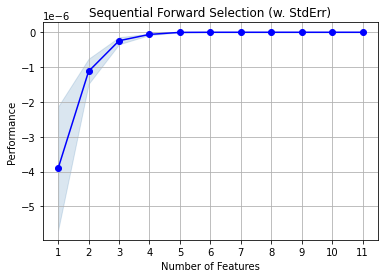

Selected features: (376, 380, 459, 523, 889, 1129, 1286, 1352, 1509, 1755, 2222)
('XLB_8', 'PG_3', 'CVCO_2', 'TRIB_8', 'HGBL_5', 'ICSA_3', 'OVBC_7', 'XLV_9')


In [294]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

lr = LinearRegression()

sfs = sfs(lr, 
          k_features=len(X_train), 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=5)

sfs = sfs.fit(X_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()
print('Selected features:', sfs.k_feature_idx_)

position = list(pd.DataFrame(sfs.subsets_).loc["avg_score"]).index(pd.DataFrame(sfs.subsets_).loc["avg_score"].max())

print(sfs.subsets_[position]['feature_names'])

In [295]:
sortedFeatures = list(sfs.subsets_[position]['feature_names'])

In [296]:
sortedFeatures

['XLB_8', 'PG_3', 'CVCO_2', 'TRIB_8', 'HGBL_5', 'ICSA_3', 'OVBC_7', 'XLV_9']

In [299]:
exclude = ''

sig_table = np.zeros(shape=(len(sortedFeatures)))
signs_table = np.zeros(shape=(len(sortedFeatures)))

p_threshold = .05

from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=num_folds)
train_ = []
test_ = []
for train_indices, test_indices in k_fold.split(X_train.index):
    train_.append(train_indices)
    test_.append(test_indices)


In [302]:

for it in range(0,len(train_)):
    max_pvalue = 1
    train_index = train_[it]
    test_index = test_[it]
    #display(all_data.iloc[test_index].describe())
    
    subset = pd.concat([X_train[sortedFeatures].iloc[train_index].loc[:, ~X_train[sortedFeatures].columns.isin([exclude])],y_train],axis=1)
    
    #skip y and states
    set_ = subset.loc[:, ~subset.columns.isin([target])].columns.tolist()
    
    n=len(subset)
    
    while(max_pvalue>=.05):

        dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
        p_values = pd.DataFrame(2*dist.cdf(-abs(subset.pcorr()[target]))).T
        p_values.columns = list(subset.columns)
        
        max_pname = p_values.idxmax(axis=1)[0]
        max_pvalue = p_values[max_pname].values[0]
        
        if (max_pvalue > .05):

            set_.remove(max_pname)
            temp = [target]
            temp.extend(set_)
            subset = subset[temp]
    
    winners = p_values.loc[:, ~p_values.columns.isin([target])].columns.tolist()
    sig_table = (sig_table + np.where(X_train[sortedFeatures].columns.isin(winners),1,0)).copy()
    signs_table[X_train[sortedFeatures].columns.get_indexer(winners)]+=np.where(subset.pcorr()[target][winners]<0,-1,1)

invalid value encountered in sqrt
invalid value encountered in sqrt


In [308]:
significance = pd.DataFrame(sig_table).T
significance.columns = list(X_train[sortedFeatures].columns)
display(significance)

sign = pd.DataFrame(signs_table).T
sign.columns = list(X_train[sortedFeatures].columns)
display(sign)

purity = abs((sign/num_folds)*(sign/significance)).T.replace([np.inf, -np.inf, np.NaN], 0)
display(purity.T)

threshold = .5

chosen = list(purity.T.columns.values[np.array(purity.T>threshold).reshape(len(X_train[sortedFeatures].columns,))])
display(chosen)

,XLB_8,PG_3,CVCO_2,TRIB_8,HGBL_5,ICSA_3,OVBC_7,XLV_9
0,4.0,3.0,4.0,4.0,3.0,3.0,4.0,3.0


,XLB_8,PG_3,CVCO_2,TRIB_8,HGBL_5,ICSA_3,OVBC_7,XLV_9
0,2.0,3.0,4.0,4.0,3.0,3.0,2.0,3.0


,XLB_8,PG_3,CVCO_2,TRIB_8,HGBL_5,ICSA_3,OVBC_7,XLV_9
0,0.2,0.6,0.8,0.8,0.6,0.6,0.2,0.6


['PG_3', 'CVCO_2', 'TRIB_8', 'HGBL_5', 'ICSA_3', 'XLV_9']

In [313]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

model = sm.OLS(y_train,X_train[chosen])
results = model.fit()

print(results.summary())

reg = LinearRegression().fit(X_train[chosen], y_train)
#reg.score(X, y)

#reg.coef_

#reg.intercept_

#import statsmodels as ssm
#X=sm.add_constant(X_train[sortedFeatures])        #to add constant value in the model
model= sm.OLS(y_train,X_train[chosen]).fit()         #fitting the model
summary = model.summary()      #summary of the model
display(summary)
print(MAPE(y_train,model.predict(X_train[chosen])))
print(MAPE(y_valid,model.predict(X_valid[chosen])))
print(MAPE(y_test,model.predict(X_test[chosen])))

                                 OLS Regression Results                                
Dep. Variable:              SPCS20RSA   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.776
Method:                 Least Squares   F-statistic:                              7.346
Date:                Sat, 14 Aug 2021   Prob (F-statistic):                      0.0224
Time:                        19:58:34   Log-Likelihood:                          44.239
No. Observations:                  11   AIC:                                     -76.48
Df Residuals:                       5   BIC:                                     -74.09
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

kurtosistest only valid for n>=20 ... continuing anyway, n=11
kurtosistest only valid for n>=20 ... continuing anyway, n=11


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SPCS20RSA   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.776
Method:                 Least Squares   F-statistic:                              7.346
Date:                Sat, 14 Aug 2021   Prob (F-statistic):                      0.0224
Time:                        19:58:34   Log-Likelihood:                          44.239
No. Observations:                  11   AIC:                                     -76.48
Df Residuals:                       5   BIC:                                     -74.09
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PG_3           0.1339      0.048      2.790      0.038       0.011       0.257
CVCO_2         0.0848      0.024      3.518      0.017       0.023       0.147
TRIB_8         0.0029      0.015      0.200      0.849      -0.035       0.040
HGBL_5         0.0051      0.011      0.468      0.660      -0.023       0.033
ICSA_3        -0.0940      0.085     -1.105      0.320      -0.313       0.125
XLV_9          0.0289      0.066      0.439      0.679      -0.140       0.198
==============================================================================
Omnibus:                        0.286   Durbin-Watson:                   2.502
Prob(Omnibus):                  0.867   Jarque-Bera (JB):                0.428
Skew:                           0.136   Prob(JB):                        0.807
Kurtosis:                       2.073   Cond. No.                         14.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

28.65034656089303
160.42190338691768
339.67666611679437


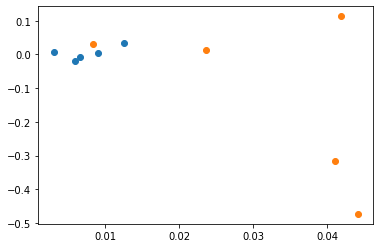

In [298]:
#plt.scatter(y_train, model.predict(X_train[sortedFeatures]))
plt.scatter(y_valid, model.predict(X_valid[sortedFeatures]))
plt.scatter(y_test, model.predict(X_test[sortedFeatures]))


In [ ]:
#testing
lagn=9
p_threshold = .05
threshold = .5

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=False)

final = pd.DataFrame()

target = "SPCS20RSA"
#print()
#print(target)
#print()
#print(f"target: {target}")

#sets = range(0,len(Training),252)
#move this outside
X_train = deltas.loc[train][set(deltas.columns).difference(target)].copy()
X_valid = deltas.loc[test][set(deltas.columns).difference(target)].copy()
y_train = deltas.loc[train][target].copy()
y_valid = deltas.loc[test][target].copy()

#X_train = deltas.loc[train][X_train.columns[~X_train.columns.isin([target])]].copy()
#X_valid = deltas.loc[test][X_train.columns[~X_train.columns.isin([target])]].copy()
#y_train = deltas.loc[train][target].copy()
#y_valid = deltas.loc[test][target].copy()

kfold = KFold(n_splits=num_folds, shuffle=False)
kfold.get_n_splits(X_train)

for m in X_train.columns:
    #print(m)

    corrs = []
    ps = []
    lags = []

    sig_table = np.zeros(shape=(2))
    signs_table = np.zeros(shape=(2))

    sets = np.zeros(shape=(num_folds,lagn))

    iterator = 0

    for train_index, test_index in kfold.split(X_train):

        subsetX = X_train.iloc[train_index]
        subsetY = y_train.iloc[train_index]

        #skip y and states

        n=len(subsetX)

        temp = pd.concat([subsetX[m].shift((lag-lagn)[0]),subsetY], axis=1).dropna()

        dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)

        chosen = pd.DataFrame()

        #train
        setc = crosscorrelation(np.array(temp[m]),np.array(temp.iloc[:,1]), lagn)
        p_values = pd.DataFrame(2*dist.cdf(-abs(setc))).T

        fields = np.argwhere(np.array(p_values)[0] <= p_threshold)

        #print(fields[fields>lagn+1]-lagn-1)
        #print(setc[fields[fields>lagn+1]])

        #sets[iterator] = (np.where(p_values <= p_threshold, True, 0)*setc)[0][lagn+1:]
        sets[iterator] = (np.array(p_values)*setc)[0][lagn+1:]             

        iterator = iterator + 1

    csets_avg = np.sum(sets, axis=0)/num_folds       

    lag = pd.DataFrame(abs(csets_avg)).idxmax()
    #print(f"correlation: {setc[lag]}")

    #pearson_coef, p_value = stats.pearsonr(np.array(temp.iloc[:,0]),np.array(temp.iloc[:,1])) #define the columns to perform calculations on

    corrs.append(csets_avg[lag])
    p_value = (2*dist.cdf(-abs(csets_avg[lag])))
    ps.append(p_value)
    lags.append(lag)    

    print(p_value)
    if (p_value < .05):
        for p in range(0,len(sets)):
            plt.plot(sets[p])   
        plt.show()

        print(target)
        print(m)
        #print(i)
        #print(f"lag: {lag-lagn}")
        #print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value) # Results
        temp1 = pd.DataFrame([target, m,(lag-lagn)[0],pearson_coef]).T
        temp1.columns = ["target","name","lag","pearson"]

        #p_values = pd.DataFrame(2*dist.cdf(-abs(temp.corr()[target]))).T
        #p_values.columns = list(temp.columns)

        #if(p_values[p_values.loc[:, ~p_values.columns.isin([target])].columns.tolist()]<=p_threshold):
        #winners = p_values.loc[:, ~p_values.columns.isin([target])].columns.tolist()
        #winners = m

        #sig_table = (sig_table + np.where(temp.columns.isin([winners]),1,0)).copy()
        #print(sig_table)
        #signs_table[temp.columns.get_indexer([winners])]+=np.where(temp.corr()[target][winners]<0,-1,1)                 
        #chosen = pd.concat([temp1,chosen],axis=0)
        chosen.append(m)

        c_threshold = dist.ppf(.05)
        plt.plot(np.sum(sets, axis=0)/num_folds)
        plt.axhline(y = 0, color = 'r', linestyle = '-')
        plt.axhline(y = c_threshold, color = 'y', linestyle = '-')
        plt.axhline(y = abs(c_threshold), color = 'y', linestyle = '-')

        plt.show()
        x=range(0,lagn)
        plt.stackplot(x,sets[0],sets[1],sets[2],sets[3],sets[4], labels=['A','B','C','D','E'])
        plt.axhline(y = 0, color = 'r', linestyle = '-')
        plt.axhline(y = c_threshold, color = 'y', linestyle = '-')
        plt.axhline(y = abs(c_threshold), color = 'y', linestyle = '-')        
        plt.show()

    #significance = pd.DataFrame(sig_table).T
    #significance.columns = list(temp.columns)
    #print(significance)

    #sign = pd.DataFrame(signs_table).T
    #sign.columns = list(temp.columns)

    #purity = abs((sign/num_folds)*(sign/significance)).T.replace([np.inf, -np.inf, np.NaN], 0)
    #print(purity)

    #ichosen = list(purity.T.columns.values[np.array(purity.T>=threshold).reshape(len(temp.columns,))])
    #print(ichosen)
    #chosen.append(ichosen)

    #print(chosen)

    #print(lags)

    #print(m)
    #print(ps)          

    for i in range(0,len(chosen)):
        values = chosen.reset_index().iloc[i]
        name = values['name']
        target = values['target']
        lag = values['lag']
        #print(lag)
        aggregate = pd.DataFrame()

        #test
        innerSet = pd.concat([X_valid[name].shift(lag),y_valid],axis=1).dropna()

        for p in range(0,len(innerSet)):     
            #print(innerSet.iloc[p][name] )
            if(innerSet.iloc[p][name] < 0):
                d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),innerSet.iloc[p][target], np.nan, 'l'])
                #print("lower")
            elif (innerSet.iloc[p][name] > 0):
                d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),np.nan, innerSet.iloc[p][target], 'u'])
                #print("upper")
            else:
                d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),np.nan, np.nan, np.nan])

            aggregate = pd.concat([d.T,aggregate],axis=0)
        #print(aggregate.loc[:,['l','u']].replace([np.inf, -np.inf, np.NaN], 0).cumsum().iloc[-1])

        aggregate.columns = "Date","l","u","class"

        pearson_coef, p_value = stats.pearsonr(np.array(innerSet.iloc[:,0]),np.array(innerSet.iloc[:,1])) #define the columns to perform calculations on

        #print(f"name: {name}", f"lag: {lag}", f"corr: {innerSet.corr().iloc[0][1]}")
        if p_value < .05 and (values['pearson']*pearson_coef) > 0:

                newData = pd.concat([pd.DataFrame(innerSet[target]).set_index(innerSet[target].index.strftime('%Y-%m-%d')),aggregate.set_index("Date")],axis=1).replace([np.inf, -np.inf, np.NaN], 0)

                if newData[[target,"l","u"]].cumsum().iloc[-1][target] < newData[[target,"l","u"]].cumsum().iloc[-1]['l'] or newData[[target,"l","u"]].cumsum().iloc[-1][target] < newData[[target,"l","u"]].cumsum().iloc[-1]['u']:
                    print(f"target: {target}")
                    print(f"name: {name}", f"lag: {lag}", f"corr: {pearson_coef}", f"p-value: {p_value}")
                    print(pd.DataFrame(newData[[target,"l","u"]].cumsum().iloc[-1]).T)

                    x_ticks = newData.index[np.arange(0, len(newData.index), 200)]

                    plt.plot(newData[[target,"l","u"]].cumsum())
                    plt.legend(loc='upper left', fancybox=True, ncol=5, labels=[target,"l","u"])
                    #plt.legend(loc="upper left",fontsize=8)

                    plt.xticks(x_ticks, rotation = 45)
                    plt.show()

                    temp1 = pd.DataFrame([target, name, pearson_coef, p_value, lag, max(newData[[target,"l","u"]].cumsum().iloc[-1][['l','u']]), newData[[target]].cumsum().iloc[-1][target] ]).T
                    final = pd.concat([temp1,final],axis=0)

final.columns = ["target","correlate","pearson","p-value","lag","TCR","holdTCR"]


In [ ]:
#testing
lagn=1
p_threshold = .05
threshold = .5

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=False)

final = pd.DataFrame()

for target in set(deltas.columns) & set(vetted_symbols):
    #print()
    #print(target)
    #print()
    #print(f"target: {target}")
    
    #sets = range(0,len(Training),252)
    #move this outside
    X_train = deltas.loc[train][X_train.columns[~X_train.columns.isin([target])]].copy()
    X_valid = deltas.loc[test][X_train.columns[~X_train.columns.isin([target])]].copy()
    y_train = deltas.loc[train][target].copy()
    y_valid = deltas.loc[test][target].copy()
    
    kfold = KFold(n_splits=num_folds, shuffle=False)
    kfold.get_n_splits(X_train)

    for m in X_train.columns:
        #print(m)
        
        corrs = []
        ps = []
        lags = []

        sig_table = np.zeros(shape=(2))
        signs_table = np.zeros(shape=(2))

        sets = np.zeros(shape=(num_folds,lagn))
        
        iterator = 0
        
        for train_index, test_index in kfold.split(X_train):

            subsetX = X_train.iloc[train_index]
            subsetY = y_train.iloc[train_index]

            #skip y and states

            n=len(subset)
            
            temp = pd.concat([subsetX[m].shift((lag-lagn)[0]),subsetY], axis=1).dropna()

            dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)

            chosen = pd.DataFrame()

            #train
            setc = crosscorrelation(np.array(temp[m]),np.array(temp.iloc[:,1]), lagn)
            p_values = pd.DataFrame(2*dist.cdf(-abs(setc))).T
            
            fields = np.argwhere(np.array(p_values)[0] <= p_threshold)
           
            #print(fields[fields>lagn+1]-lagn-1)
            #print(setc[fields[fields>lagn+1]])
            
            #sets[iterator] = (np.where(p_values <= p_threshold, True, 0)*setc)[0][lagn+1:]
            sets[iterator] = (np.array(p_values)*setc)[0][lagn+1:]             
            
            iterator = iterator + 1
        
        csets_avg = np.sum(sets, axis=0)/num_folds       
        
        lag = pd.DataFrame(abs(csets_avg)).idxmax()
        #print(f"correlation: {setc[lag]}")

        #pearson_coef, p_value = stats.pearsonr(np.array(temp.iloc[:,0]),np.array(temp.iloc[:,1])) #define the columns to perform calculations on

        corrs.append(csets_avg[lag])
        p_value = (2*dist.cdf(-abs(csets_avg[lag])))
        ps.append(p_value)
        lags.append(lag)    

        #print(p_value)
        if (p_value < .05):
            for p in range(0,len(sets)):
                plt.plot(sets[p])   
            plt.show()
            
            print(target)
            print(m)
            #print(i)
            #print(f"lag: {lag-lagn}")
            #print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value) # Results
            temp1 = pd.DataFrame([target, m,(lag-lagn)[0],pearson_coef]).T
            temp1.columns = ["target","name","lag","pearson"]

            #p_values = pd.DataFrame(2*dist.cdf(-abs(temp.corr()[target]))).T
            #p_values.columns = list(temp.columns)

            #if(p_values[p_values.loc[:, ~p_values.columns.isin([target])].columns.tolist()]<=p_threshold):
            #winners = p_values.loc[:, ~p_values.columns.isin([target])].columns.tolist()
            winners = m

            #sig_table = (sig_table + np.where(temp.columns.isin([winners]),1,0)).copy()
            #print(sig_table)
            #signs_table[temp.columns.get_indexer([winners])]+=np.where(temp.corr()[target][winners]<0,-1,1)                 
            #chosen = pd.concat([temp1,chosen],axis=0)
            chosen.append(m)

            c_threshold = dist.ppf(.05)
            plt.plot(np.sum(sets, axis=0)/num_folds)
            plt.axhline(y = 0, color = 'r', linestyle = '-')
            plt.axhline(y = c_threshold, color = 'y', linestyle = '-')
            plt.axhline(y = abs(c_threshold), color = 'y', linestyle = '-')

            plt.show()
            x=range(0,lagn)
            plt.stackplot(x,sets[0],sets[1],sets[2],sets[3],sets[4], labels=['A','B','C','D','E'])
            plt.axhline(y = 0, color = 'r', linestyle = '-')
            plt.axhline(y = c_threshold, color = 'y', linestyle = '-')
            plt.axhline(y = abs(c_threshold), color = 'y', linestyle = '-')        
            plt.show()

        #significance = pd.DataFrame(sig_table).T
        #significance.columns = list(temp.columns)
        #print(significance)

        #sign = pd.DataFrame(signs_table).T
        #sign.columns = list(temp.columns)

        #purity = abs((sign/num_folds)*(sign/significance)).T.replace([np.inf, -np.inf, np.NaN], 0)
        #print(purity)

        #ichosen = list(purity.T.columns.values[np.array(purity.T>=threshold).reshape(len(temp.columns,))])
        #print(ichosen)
        #chosen.append(ichosen)
        
        #print(chosen)
        
        #print(lags)
        
        #print(m)
        #print(ps)          
        
        for i in range(0,len(chosen)):
            values = chosen.reset_index().iloc[i]
            name = values['name']
            target = values['target']
            lag = values['lag']
            #print(lag)
            aggregate = pd.DataFrame()

            #test
            innerSet = pd.concat([X_valid[name].shift(lag),y_valid],axis=1).dropna()

            for p in range(0,len(innerSet)):     
                #print(innerSet.iloc[p][name] )
                if(innerSet.iloc[p][name] < 0):
                    d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),innerSet.iloc[p][target], np.nan, 'l'])
                    #print("lower")
                elif (innerSet.iloc[p][name] > 0):
                    d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),np.nan, innerSet.iloc[p][target], 'u'])
                    #print("upper")
                else:
                    d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),np.nan, np.nan, np.nan])

                aggregate = pd.concat([d.T,aggregate],axis=0)
            #print(aggregate.loc[:,['l','u']].replace([np.inf, -np.inf, np.NaN], 0).cumsum().iloc[-1])

            aggregate.columns = "Date","l","u","class"

            pearson_coef, p_value = stats.pearsonr(np.array(innerSet.iloc[:,0]),np.array(innerSet.iloc[:,1])) #define the columns to perform calculations on

            #print(f"name: {name}", f"lag: {lag}", f"corr: {innerSet.corr().iloc[0][1]}")
            if p_value < .05 and (values['pearson']*pearson_coef) > 0:

                    newData = pd.concat([pd.DataFrame(innerSet[target]).set_index(innerSet[target].index.strftime('%Y-%m-%d')),aggregate.set_index("Date")],axis=1).replace([np.inf, -np.inf, np.NaN], 0)

                    if newData[[target,"l","u"]].cumsum().iloc[-1][target] < newData[[target,"l","u"]].cumsum().iloc[-1]['l'] or newData[[target,"l","u"]].cumsum().iloc[-1][target] < newData[[target,"l","u"]].cumsum().iloc[-1]['u']:
                        print(f"target: {target}")
                        print(f"name: {name}", f"lag: {lag}", f"corr: {pearson_coef}", f"p-value: {p_value}")
                        print(pd.DataFrame(newData[[target,"l","u"]].cumsum().iloc[-1]).T)

                        x_ticks = newData.index[np.arange(0, len(newData.index), 200)]

                        plt.plot(newData[[target,"l","u"]].cumsum())
                        plt.legend(loc='upper left', fancybox=True, ncol=5, labels=[target,"l","u"])
                        #plt.legend(loc="upper left",fontsize=8)

                        plt.xticks(x_ticks, rotation = 45)
                        plt.show()

                        temp1 = pd.DataFrame([target, name, pearson_coef, p_value, lag, max(newData[[target,"l","u"]].cumsum().iloc[-1][['l','u']]), newData[[target]].cumsum().iloc[-1][target] ]).T
                        final = pd.concat([temp1,final],axis=0)

final.columns = ["target","correlate","pearson","p-value","lag","TCR","holdTCR"]


In [ ]:
final

In [ ]:
results2 = pd.DataFrame()

for i in range(0,len(final)):
    values = final.reset_index().iloc[i]
    name = values['correlate']
    target = values['target']
    lag = values['lag']
    #print(lag)
    aggregate = pd.DataFrame()

    X_test = deltas.loc[test][set(deltas.columns).difference(target)]
    y_test = deltas.loc[test][target]
    
    #test
    innerSet = pd.concat([X_test[name].shift(lag),y_test],axis=1).dropna()

    for p in range(0,len(innerSet)):     
        #print(innerSet.iloc[p][name] )
        if(innerSet.iloc[p][name] < 0):
            d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),innerSet.iloc[p][target], np.nan, 'l'])
            #print("lower")
        elif (innerSet.iloc[p][name] > 0):
            d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),np.nan, innerSet.iloc[p][target], 'u'])
            #print("upper")
        else:
            d = pd.DataFrame([innerSet.index[p].strftime('%Y-%m-%d'),np.nan, np.nan, np.nan])

        aggregate = pd.concat([d.T,aggregate],axis=0)
    #print(aggregate.loc[:,['l','u']].replace([np.inf, -np.inf, np.NaN], 0).cumsum().iloc[-1])

    aggregate.columns = "Date","l","u","class"

    pearson_coef, p_value = stats.pearsonr(np.array(innerSet.iloc[:,0]),np.array(innerSet.iloc[:,1])) #define the columns to perform calculations on

    #print(f"name: {name}", f"lag: {lag}", f"corr: {innerSet.corr().iloc[0][1]}")
    if p_value < .05:

            newData = pd.concat([pd.DataFrame(innerSet[target]).set_index(innerSet[target].index.strftime('%Y-%m-%d')),aggregate.set_index("Date")],axis=1).replace([np.inf, -np.inf, np.NaN], 0)

            if newData[[target,"l","u"]].cumsum().iloc[-1][target] < newData[[target,"l","u"]].cumsum().iloc[-1]['l'] or newData[[target,"l","u"]].cumsum().iloc[-1][target] < newData[[target,"l","u"]].cumsum().iloc[-1]['u']:
                print(f"target: {target}")
                print(f"name: {name}", f"lag: {lag}", f"corr: {pearson_coef}", f"p-value: {p_value}")
                print(pd.DataFrame(newData[[target,"l","u"]].cumsum().iloc[-1]).T)

                x_ticks = newData.index[np.arange(0, len(newData.index), 200)]

                plt.plot(newData[[target,"l","u"]].cumsum())
                plt.legend(loc='upper left', fancybox=True, ncol=5, labels=[target,"l","u"])
                #plt.legend(loc="upper left",fontsize=8)

                plt.xticks(x_ticks, rotation = 45)
                plt.show()

                temp1 = pd.DataFrame([target, name, pearson_coef, p_value, lag, max(newData[[target,"l","u"]].cumsum().iloc[-1][['l','u']]), newData[[target]].cumsum().iloc[-1][target] ]).T
                results2 = pd.concat([temp1,results2],axis=0)
                
results2.columns = ["target","correlate","pearson","p-value","lag","TCR","holdTCR"]                

In [ ]:
len(final)

In [ ]:
results2

In [ ]:
pd.concat([final['pearson'],results2['pearson']],axis=1)

In [ ]:
pd.concat([final['pearson']*results2['pearson']],axis=1)

In [ ]:
aggregate = pd.DataFrame()

for s in Training:
    #print(s)
    set_dates = s
    #print(set_dates[1])
    #print(set_dates[-1])
    
    #rate of change compare
    filtered2 =  pd.concat([truncatedData.loc[[i[0] for i in set_dates]][compare],truncatedData.loc[[i[0] for i in set_dates]][target]],axis=1).pct_change().dropna().replace([np.inf, -np.inf, np.NaN], 0)
    #quantiles2 = filtered2[compare].quantile(q=[0, .25, .5, .75, 1], interpolation='linear')

    #prop_cycle = plt.rcParams['axes.prop_cycle']
    #colors = cycle(prop_cycle.by_key()['color'])
    
    #subset, Holdout = split_sequences(np.array(pd.DataFrame(filtered2.index.strftime('%Y-%m-%d'))), 126, 0)
    
    #for i in subset:
        
    #quantiles = pd.DataFrame(filtered2.iloc[0:-2][compare].quantile([0,.5,1]),columns=['min','median','max'])
    #np.percentile((filtered2.iloc[0:-2][compare]),50)
    
    t = pd.DataFrame(filtered2.iloc[0:-3][compare].quantile([0,.5,1])).T
    t.columns = ['min','median','max']
    quantiles = t.reset_index(drop=True)

    #lower = filtered2.iloc[0:-1][(filtered2.iloc[0:-2][compare]<=quantile)].index
    #upper = ~filtered2.iloc[0:-2].index.isin(lower)



    #my_dpi = 100
    #fig, axes = plt.subplots(figsize=(12, 4),ncols=3, nrows=1)
    #ax1, ax2, ax3 = axes.ravel()
    #sns.set(style="ticks")
    #sns.despine(fig=fig)

    #dataframe = filtered2.loc[dates]
    #returns = dataframe[target].dropna()

    #l = np.where(filtered2.iloc[0:-2][compare] <= quantile, filtered2.iloc[-1][target], 0)
    #u = np.where(filtered2.iloc[upper][compare] > quantile, filtered2.iloc[-1][target], 0)
    if((filtered2.iloc[-2][compare] <= quantiles['median'][0])):
        d = pd.DataFrame([filtered2.iloc[-1][target], np.nan, 'l'])
    else:
        d = pd.DataFrame([np.nan, filtered2.iloc[-1][target], 'u'])
    #d = pd.concat([pd.DataFrame(l.tolist()),pd.DataFrame(u.tolist())],axis=1)
    #print(len(d))
    #print(d)
    
    #print(pd.concat([d.T, quantiles.T.reset_index(drop=True)],axis=1))
    #aggregate = pd.concat([d.T, quantiles.T.reset_index(drop=True), aggregate],axis=0)
    aggregate = pd.concat([pd.concat([d.T, quantiles],axis=1),aggregate],axis=0)
    #print(aggregate)
    #print(len(aggregate))
    #print(aggregate)
    #d.index = filtered2.iloc[-1].name.strftime('%Y-%m-%d')
   
    #sns.regplot(x=compare, y=target, data=dataframe, ax=ax1)

    #sns.violinplot(x=dataframe[compare].dropna(),color=next(colors), ax=ax2)

    #sns.vioinplot(x=returns,color=next(colors), ax=ax3) 
    #plt.show()




In [ ]:
len(Training)

aggregate.columns = ['l','u','class','min','median','max']

dates = []
for item in Training:
    last = item[-1]
    dates.append(last[0])
    
aggregate.loc[:,['l','u']].replace([np.inf, -np.inf, np.NaN], 0).cumsum().iloc[-1]

aggregate.index=dates

#print(aggregate.cumsum().iloc[-1])
#aggregate.reset_index()
#ax = sns.regplot(x=aggregate.columns[1], y='index', data=aggregate.reset_index())

x_ticks = aggregate.index[np.arange(0, len(aggregate.index), 200)]

plt.plot(aggregate.loc[:,['l']].replace([np.inf, -np.inf, np.NaN], 0).cumsum())

plt.xticks(x_ticks, rotation = 45)
plt.show()

In [ ]:
temp1 = pd.concat([truncatedData[compare].pct_change(),truncatedData[target]],axis=1).loc[dates]
temp2 = pd.concat([truncatedData[compare].pct_change(),truncatedData[target].pct_change()],axis=1).loc[dates]
temp1.index = temp1.index.copy().strftime('%Y-%m-%d')
temp2.index = temp2.index.copy().strftime('%Y-%m-%d')
temp = pd.concat([temp1,temp2,aggregate],axis=1)
newNames = [compare,target,compare+"_pct_change",target+"_pct_change"]
newNames.extend(temp.columns[4:10])
temp.columns = newNames

temp.to_csv('../data/processed/output.csv', index=True) 

In [ ]:
from sklearn import metrics
#scores = np.where(temp[compare] > 1, 1, 0)

#idk why this library uses 2, 1 vs 1 and 0
fpr, tpr, thresholds = metrics.roc_curve(np.where(temp[target+"_pct_change"] > 0, 2, 1), np.array(temp[compare+"_pct_change"].shift(-1)) , pos_label=2)

In [ ]:
metrics.plot_roc_curve(clf, X_test, y_test)  

In [ ]:
from sklearn.metrics import roc_curve
#plt.plot(fpr,tpr, label='AUC = ' + str(round(roc_auc_score(y,m.oob_decision_function_[:,1]), 2)))
#plt.legend(loc='lower right')

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(np.where(temp[target+"_pct_change"] > 0, 1, 0), np.array(temp[compare+"_pct_change"]), labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [ ]:


print("optimal cutoff")
#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
Find_Optimal_Cutoff(np.where(temp[target+"_pct_change"] > 0, 1, 0), np.array(temp[compare+"_pct_change"]))


In [ ]:
from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(fpr, tpr, S=1.0, curve="concave", direction="increasing")
#kneedle.plot_knee_normalized()
kneedle.plot_knee()

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]


In [ ]:
plt.scatter(aggregate[aggregate['bifur']=='l'].iloc[:,0].cumsum(),  truncatedData[target].pct_change().loc[aggregate[aggregate['bifur']=='l'].iloc[:,0].index.tolist()])
plt.show()
aggregate[aggregate['bifur']=='l'].iloc[:,0].hist()
plt.show()

In [ ]:
plt.scatter(aggregate[aggregate['bifur']=='u'].iloc[:,1].cumsum(),  truncatedData[target].pct_change().loc[aggregate[aggregate['bifur']=='u'].iloc[:,1].index.tolist()])
plt.show()
aggregate[aggregate['bifur']=='u'].iloc[:,1].hist()
plt.show()

In [ ]:
#252 trading days a year
#30 days = 21
#60 = 42
#90 = 63

#return = current - prior / prior

#for i in range(1,63): #[1,21,42,63]
for i in [1,21,42,63,84]: #[1,21,42,84]
    print(i)
    rate_of_change = (truncatedData[compare]-truncatedData[compare].shift(i))/truncatedData[compare].shift(i)
    
    newDF = pd.concat([rate_of_change,truncatedData[target].pct_change()],axis=1).dropna()

    set1 = newDF[compare]
    set2 = newDF[target]
    
    lags = range(0,85) #[0,21,42,63]
    mcorrs_ = []
    mlags = []
    for j in lags:
        
        newSet = pd.concat([set1.shift(j),set2],axis=1).dropna()
      
        mcorrs_.append(np.array(newSet.corr())[1,0])
        
    plt.plot(mcorrs_)
    plt.show()





In [ ]:
pd.concat([(truncatedData[compare]-truncatedData[compare].shift(1))/truncatedData[compare].shift(1),truncatedData[target].pct_change().shift(0)],axis=1).dropna().corr()

In [ ]:
plt.scatter((truncatedData[compare]-truncatedData[compare].shift(1))/truncatedData[compare].shift(1),truncatedData[target].pct_change().shift(0))

In [ ]:
#import matplotlib.pyplot as plt
#plt.matshow(
df = combined_set.loc[combined_set.index>=start_date.strftime('%Y-%m-%d')]

r_ = df.corr()

filter = r_[compare]
                       
filter = filter[filter<1]
filter = filter.sort_values(kind="quicksort", ascending=True)
print(filter.head(10))
print(filter.tail(10))
